Program 2 - Text classification
* The goal is to design a model able to classify text in 
two classes, predicting the sentiment polarity of Yelp Reviews
* Data are available in the NLP section of fast.ai datasets website
  * Dataset is rather large, you may use a subset of it
  * Labels are 1 or 2, you may change them
* You can implement a model described in the papers or your own one
  * Models like the ones seen for IMDB Sentiment classification
  * Transformer models; Transfer Learning
* Objectives
  * First design a model that you can train, without targeting the highest classification accuracy
  * Second tune the model to obtain the best possible classification performance
 

<b>Submitted By:</b>
>   <li>  <a href="https://motiur.info" target="_blank"> Sheikh Shah Mohammad Motiur Rahman</a></li>
>    <li> <a href="https://b.gorelkin.me" target="_blank">Bogdan Gorelkin </a></li>

# Start with BERT (Bidirectional Encoder Representations from Transformers).

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Download YELP Review Dataset

In [3]:
!wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz

--2021-01-09 11:21:03--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.10.254
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.10.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166373201 (159M) [application/x-tar]
Saving to: ‘yelp_review_polarity_csv.tgz’

yelp_review_polarit 100%[===================>] 158.67M  55.4MB/s    in 2.9s    

2021-01-09 11:21:06 (55.4 MB/s) - ‘yelp_review_polarity_csv.tgz’ saved [166373201/166373201]



Extract the Dataset

In [4]:
!tar -xvzf yelp_review_polarity_csv.tgz

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv


Read and explore the data in the dataset

In [5]:
import pandas as pd

In [6]:
train_df = pd.read_csv("yelp_review_polarity_csv/train.csv", header=None)

In [7]:
train_df

,0,1
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


In [8]:
train_df.iloc[0][1]

"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."

In [9]:
test_df = pd.read_csv("yelp_review_polarity_csv/test.csv", header=None)

In [10]:
test_df.shape

(38000, 2)

In [11]:
test_df.head()

,0,1
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


As we can see, the data is in the two csv files train.csv and test.csv. They contain no headers, and two columns for the label and the text. The labels used here feel a little weird to me, as they have used 1 and 2 instead of the typical 0 and 1. Here, a label of 1 means the review is bad, and a label of 2 means the review is good. We are going to change this to the more familiar 0 and 1 labelling, where a label 0 indicates a bad review, and a label 1 indicates a good review.

In [12]:
train_df[0] = (train_df[0] == 2).astype(int)
test_df[0] = (test_df[0] == 2).astype(int)

train_df.head(12)

,0,1
0,0,"Unfortunately, the frustration of being Dr. Go..."
1,1,Been going to Dr. Goldberg for over 10 years. ...
2,0,I don't know what Dr. Goldberg was like before...
3,0,I'm writing this review to give you a heads up...
4,1,All the food is great here. But the best thing...
5,0,Wing sauce is like water. Pretty much a lot of...
6,0,Owning a driving range inside the city limits ...
7,0,This place is absolute garbage... Half of the...
8,1,Before I finally made it over to this range I ...
9,1,I drove by yesterday to get a sneak peak. It ...


In [13]:
test_df.head()

,0,1
0,1,"Contrary to other reviews, I have zero complai..."
1,0,Last summer I had an appointment to get new ti...
2,1,"Friendly staff, same starbucks fair you get an..."
3,0,The food is good. Unfortunately the service is...
4,1,Even when we didn't have a car Filene's Baseme...


Add column name for better representation

In [14]:
train_df_bert = pd.DataFrame({
    "id": range(len(train_df)),
    "label": train_df[0],
    "sentence": train_df[1].replace(r'\n', ' ', regex=True)
})

train_df_bert.head()

,id,label,sentence
0,0,0,"Unfortunately, the frustration of being Dr. Go..."
1,1,1,Been going to Dr. Goldberg for over 10 years. ...
2,2,0,I don't know what Dr. Goldberg was like before...
3,3,0,I'm writing this review to give you a heads up...
4,4,1,All the food is great here. But the best thing...


In [15]:
test_df_bert = pd.DataFrame({
    "id": range(len(test_df)),
    "label": test_df[0],
    "sentence": test_df[1].replace(r'\n', ' ', regex=True)
})

test_df_bert.head()

,id,label,sentence
0,0,1,"Contrary to other reviews, I have zero complai..."
1,1,0,Last summer I had an appointment to get new ti...
2,2,1,"Friendly staff, same starbucks fair you get an..."
3,3,0,The food is good. Unfortunately the service is...
4,4,1,Even when we didn't have a car Filene's Baseme...


In [16]:

train_df_bert

,id,label,sentence
0,0,0,"Unfortunately, the frustration of being Dr. Go..."
1,1,1,Been going to Dr. Goldberg for over 10 years. ...
2,2,0,I don't know what Dr. Goldberg was like before...
3,3,0,I'm writing this review to give you a heads up...
4,4,1,All the food is great here. But the best thing...
...,...,...,...
559995,559995,1,Ryan was as good as everyone on yelp has claim...
559996,559996,1,Professional \nFriendly\nOn time AND affordabl...
559997,559997,0,Phone calls always go to voicemail and message...
559998,559998,0,Looks like all of the good reviews have gone t...


As dataset have large amount of data, we will select 10000 and 3000 data for train and test respectively.

In [17]:
train_df_bert = train_df_bert.iloc[0:10000]

In [18]:
train_df_bert

,id,label,sentence
0,0,0,"Unfortunately, the frustration of being Dr. Go..."
1,1,1,Been going to Dr. Goldberg for over 10 years. ...
2,2,0,I don't know what Dr. Goldberg was like before...
3,3,0,I'm writing this review to give you a heads up...
4,4,1,All the food is great here. But the best thing...
...,...,...,...
9995,9995,0,Worst Japanese food in town! I go here about o...
9996,9996,1,Yum!\n\nIt's been a family tradition to go her...
9997,9997,0,I came here after graduating back in May and m...
9998,9998,0,"Welcome to Restaurant Hell, courtesy of Kamaku..."


In [19]:
test_df_bert = test_df_bert.iloc[0:3000]

In [20]:
test_df_bert

,id,label,sentence
0,0,1,"Contrary to other reviews, I have zero complai..."
1,1,0,Last summer I had an appointment to get new ti...
2,2,1,"Friendly staff, same starbucks fair you get an..."
3,3,0,The food is good. Unfortunately the service is...
4,4,1,Even when we didn't have a car Filene's Baseme...
...,...,...,...
2995,2995,0,In a word...grody.\n\nThe second I walked in t...
2996,2996,0,I just sent the following message through thei...
2997,2997,1,This was my first time here and enjoyed the pi...
2998,2998,0,DON'T EVER GO HERE FOR ANYTHING!!! ITS TERRIBL...


Extract the sentences and labels of our training and test set as numpy ndarrays.

In [ ]:
# Get the lists of sentences and their labels.
train_sentences = train_df_bert.sentence.values
train_labels = train_df_bert.label.values

In [ ]:
# Get the lists of sentences and their labels.
test_sentences = test_df_bert.sentence.values
test_labels = test_df_bert.label.values

In [ ]:
!pip install transformers==3.0.0

Tokenization & Input Formatting

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Tokenizer test

In [ ]:
# Print the original sentence.
print(' Original: ', train_sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences[0])))

 Original:  Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.
Tokenized:  ['unfortunately', ',', 'the', 'frustration', 'of', 'being', 'dr', '.', 'goldberg', "'", 's', 'patient', 'is', 'a', 'repeat', 'of', 'the', 'experience', 'i', "'", 've', 'had', 'with', 'so', 'many', 'other', 'doctors', 'in', 'nyc', '-', '-', 'good', 'doctor', ',', 'terrible', 'staff', '.', 'it', 'seems', 'that', 'his', 'staff', 'sim

**Tokenize Dataset:** The transformers library provides a helpful encode function which will handle most of the parsing and data prep steps for us.
Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.
The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

max_len_train = 0

# For every sentence...
for sent in train_sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent[:512], add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_train = max(max_len_train, len(input_ids))

print('Max sentence length: ', max_len_train)

Max sentence length:  199


In [ ]:
max_len_test = 0

# For every sentence...
for sent in test_sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent[:512], add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_test = max(max_len_test, len(input_ids))

print('Max sentence length: ', max_len_test)

Max sentence length:  239


As the sequence that is larger than the max sequence the model can handle (which is 512 tokens). This is not an error but a warning; but if I pass that sequence to the model it will crash as it cannot handle such a long sequence.
Just in case there are some longer test sentences, I'll set the maximum length to 300.

Now we're ready to perform the real tokenization.
The tokenizer.encode_plus function combines multiple steps for us:
Split the sentence into tokens.
Add the special [CLS] and [SEP] tokens.
Map the tokens to their IDs.
Pad or truncate all sentences to the same length.
Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
The first four features are in tokenizer.encode, but I'm using tokenizer.encode_plus to get the fifth item (attention masks). 

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in train_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', train_sentences[0])
print('Token IDs:', input_ids[0])

Original:  Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.
Token IDs: tensor([  101,  6854,  1010,  1996,  9135,  1997,  2108,  2852,  1012, 18522,
         1005,  1055,  5776,  2003,  1037,  9377,  1997,  1996,  3325,  1045,
         1005,  2310,  2018,  2007,  2061,  2116,  2060,  7435,  1999, 16392,
         1011,  1011,  2204,  3460,  1010,  6659,  3095,  1012,  2009,  3849,
         2008,  2010, 

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_test = []
attention_masks_test = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels_test = torch.tensor(test_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_sentences[0])
print('Token IDs:', input_ids_test[0])

Original:  Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Boys, these guys are experienced and know what they're doing. \nAlso, this is one place that I do not feel like I am being taken advantage of, just because of my gender. Other auto mechanics have been notorious for capitalizing on my ignorance of cars, and have sucked my bank account dry. But here, my service and road coverage has all been well explained - and let up to me to decide. \nAnd they just renovated the waiting room. It looks a lot better than it did in previous years.
Token IDs: tensor([  101, 10043,  2000,  2060,  4391,  1010,  1045,  2031,  5717, 10821,
         2055,  1996,  2326,  2030,  1996,  7597,  1012,  1045,  2031,  2042,
         2893, 12824,  2326,  2182,  2005,  1996,  2627,  1019,  2086,  2085,
         1010,  1998,  4102,  2000,  2026,  3325,  2007,  3182

**Training & Validation Split:** Divide up our training set to use 90% for training and 10% for validation.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

9,000 training samples
1,000 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

**Train Our Classification Model: BertForSequenceClassification**

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
bert = 'bert-large-uncased'
config = BertConfig.from_pretrained('bert-large-uncased', output_hidden_states=True, hidden_dropout_prob=0.2, 
attention_probs_dropout_prob=0.2)
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Just for curiosity's sake, we can browse all of the model's parameters by name here.
In the below cell, I've printed out the names and dimensions of the weights for:
The embedding layer.
The first of the twelve transformers.
The output layer.

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

**Optimizer & Learning Rate Scheduler**

*Now* that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

**Training Loop**

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

Define a helper function for calculating accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as hh:mm:ss

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

We're ready for the training!

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    282.    Elapsed: 0:01:14.
  Batch    80  of    282.    Elapsed: 0:02:28.
  Batch   120  of    282.    Elapsed: 0:03:42.
  Batch   160  of    282.    Elapsed: 0:04:56.
  Batch   200  of    282.    Elapsed: 0:06:11.
  Batch   240  of    282.    Elapsed: 0:07:26.
  Batch   280  of    282.    Elapsed: 0:08:40.

  Average training loss: 0.23
  Training epcoh took: 0:08:42

Running Validation...
  Accuracy: 0.94
  Validation Loss: 0.16
  Validation took: 0:00:22

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    282.    Elapsed: 0:01:14.
  Batch    80  of    282.    Elapsed: 0:02:29.
  Batch   120  of    282.    Elapsed: 0:03:44.
  Batch   160  of    282.    Elapsed: 0:04:58.
  Batch   200  of    282.    Elapsed: 0:06:13.
  Batch   240  of    282.    Elapsed: 0:07:27.
  Batch   280  of    282.    Elapsed: 0:08:42.

  Average training loss: 0.11
  Training epcoh took: 0:08:44

Running Validation...
  Accuracy: 0.96
 

Summary of the training process.

In [ ]:

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.23,0.16,0.94,0:08:42,0:00:22
2,0.11,0.16,0.96,0:08:44,0:00:21
3,0.05,0.20,0.95,0:08:42,0:00:21
4,0.02,0.24,0.95,0:08:42,0:00:21


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data.
(For reference, we are using 9000 training samples and 1000 validation samples).
Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on.
If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

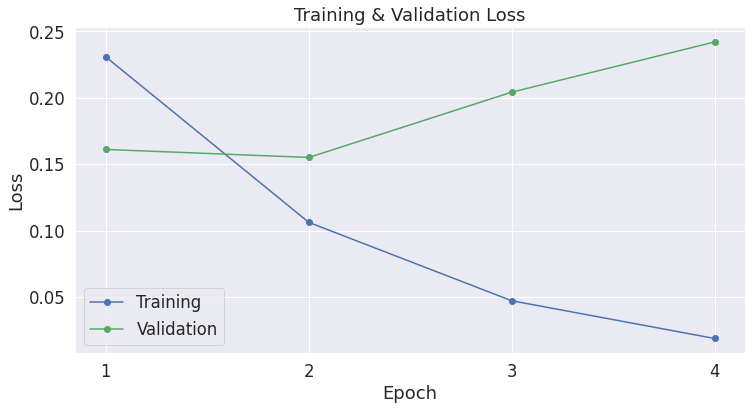

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

**Performance On Test Set**

In [ ]:
# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,000 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (test_df_bert.label.sum(), len(test_df_bert.label), (test_df_bert.label.sum() / len(test_df_bert.label) * 100.0)))

Positive samples: 1380 of 3000 (46.00%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


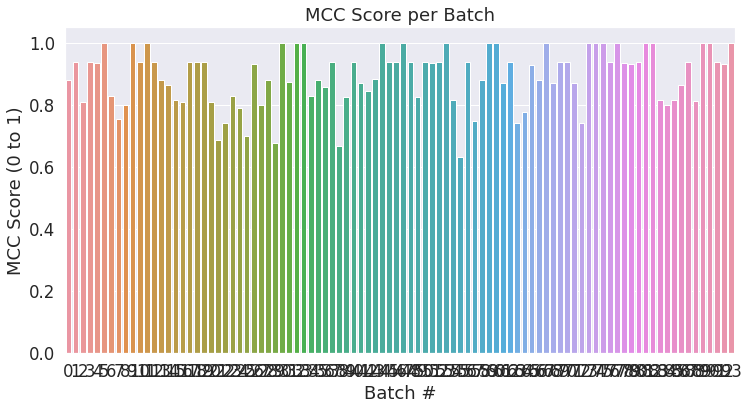

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (0 to 1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.893


To maximize the score, we should remove the "validation set" (which we used to help determine how many epochs to train for) and train on the entire training set.

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

# CNN Classifiers

Load the previous train test data for applying new algorithm. And split data for further process.

In [21]:
train_df_bert.head()

,id,label,sentence
0,0,0,"Unfortunately, the frustration of being Dr. Go..."
1,1,1,Been going to Dr. Goldberg for over 10 years. ...
2,2,0,I don't know what Dr. Goldberg was like before...
3,3,0,I'm writing this review to give you a heads up...
4,4,1,All the food is great here. But the best thing...


In [22]:
(x_train, y_train), (x_test, y_test) = (train_df_bert.sentence,train_df_bert.label),(test_df_bert.sentence,test_df_bert.label)

**Text preprocessing and sequence preprocessing:** Tokenizer utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. You can add the parameter num_words, which is responsible for setting the size of the vocabulary. The most common num_words words will be then kept.

In [28]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)


In [39]:
from keras.preprocessing import sequence
# 2 - Define the number of words to be used from a review (truncate and pad input sequences)
print('Pad sequences (samples x time)')

max_review_length = 1400

x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
print('X_train shape:',x_train.shape)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)
print('X_test shape:',x_test.shape)

Pad sequences (samples x time)
X_train shape: (10000, 1400)
X_test shape: (3000, 1400)


**Define the model Architecture**

In [54]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D,MaxPooling1D
from keras.layers import Embedding

# 3 - Neural network model design
print('Building model')
max_features = 5000
embedding_vector_length = 128

filters = 250
kernel_size = 3
hidden_dims = 125

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length=max_review_length))
#model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
#model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Building model
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1400, 128)         640000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1398, 250)         96250     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 250)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 125)               31375     
_________________________________________________________________
activation_10 (Activation)   (None, 125)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 126       
_________________________________________________________________
activation_11 (Activation)   (None, 1) 

**Train and Evaluate**

In [46]:
# 4 - Train the neural network model
history = model.fit(x_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9990
Testing Accuracy:  0.9003


**Visualization of result**

In [51]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


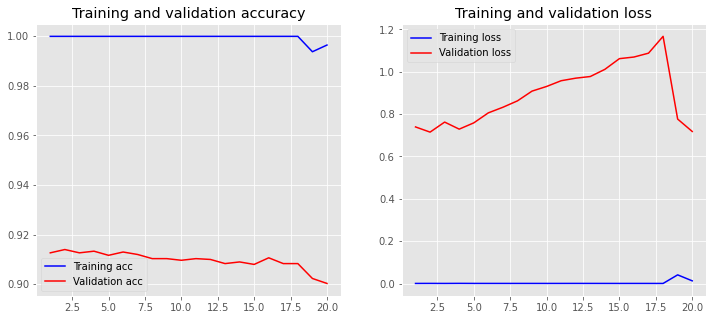

In [52]:
plot_history(history)

**CNN-LSTM**

In [57]:
# 3 - Neural network model design
print('Building model')

embedding_vector_length = 32

model = Sequential()
model.add(Embedding(max_features, embedding_vector_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Building model
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1400, 32)          160000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1400, 32)          3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 700, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 101       
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9998
Testing Accuracy:  0.8857


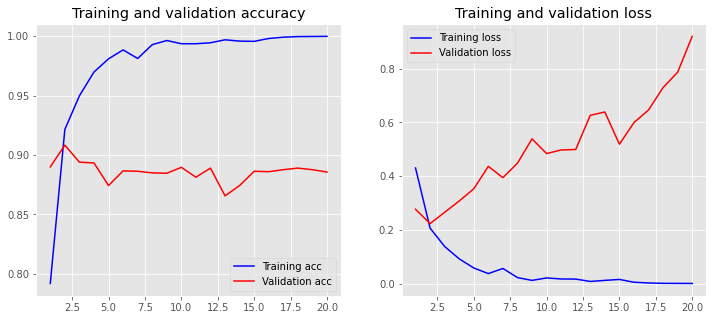

In [58]:
#  - Train the neural network model
history1 = model.fit(x_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history1)

# Optimization of CNN and CNNLSTM

In [68]:
max_features = 5000
def CreateModel(epoch,network,optimizer):
  if network == 'CNN':

    # 3 - Neural network model design
    print('Building model')
    
    embedding_vector_length = 128

    filters = 250
    kernel_size = 3
    hidden_dims = 125

    model = Sequential()
    model.add(Embedding(max_features, embedding_vector_length, input_length=max_review_length))
    #model.add(Dropout(0.2))
    model.add(Conv1D(filters,
                    kernel_size,
                    padding='valid',
                    activation='relu',
                    strides=1))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(hidden_dims))
    #model.add(Dropout(0.2))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()
  if network == 'CNNLSTM':
    print('Building model')

    embedding_vector_length = 32

    model = Sequential()
    model.add(Embedding(max_features, embedding_vector_length, input_length=max_review_length))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
  return model



In [69]:
def finalEvaluation(epoch,network,optimizer):
  model = CreateModel(epoch,network,optimizer)
  history = model.fit(x_train, y_train,
                    epochs=epoch,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)
  loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
  print("Training Accuracy: {:.4f}".format(accuracy))
  loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
  print("Testing Accuracy:  {:.4f}".format(accuracy))
  plot_history(history)

Building model
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1400, 32)          160000    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1400, 32)          3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 700, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9973
Testing Accuracy:  0.8987


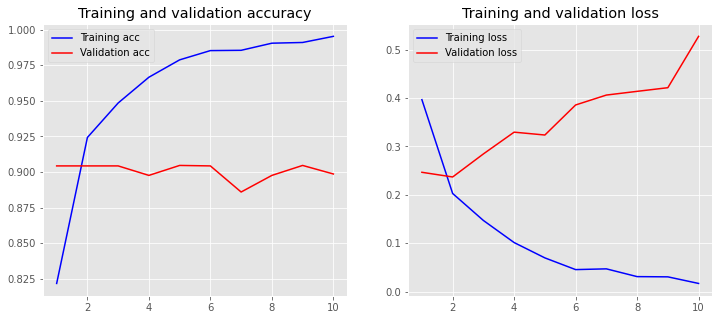

In [70]:
finalEvaluation(10,'CNNLSTM','Nadam')

Building model
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1400, 32)          160000    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1400, 32)          3104      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 700, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9976
Testing Accuracy:  0.8930


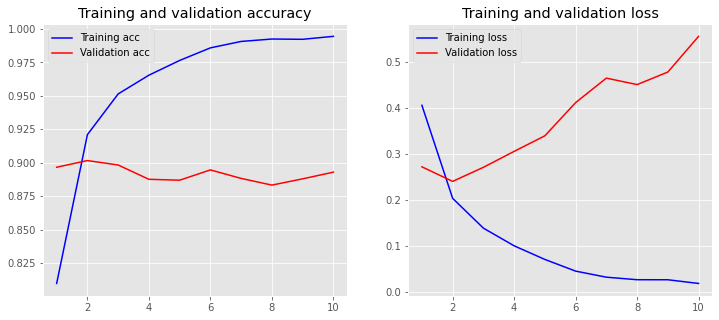

In [71]:
finalEvaluation(10,'CNNLSTM','rmsprop')

Building model
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 1400, 32)          160000    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1400, 32)          3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 700, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 0.9981
Testing Accuracy:  0.8923


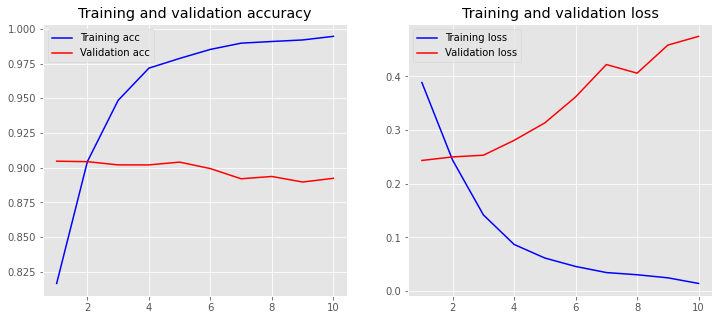

In [72]:
finalEvaluation(10,'CNNLSTM','SGD')

Building model
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 1400, 128)         640000    
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1398, 250)         96250     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 250)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 125)               31375     
_________________________________________________________________
activation_12 (Activation)   (None, 125)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 126       
_________________________________________________________________
activation_13 (Activation)   (None, 1)

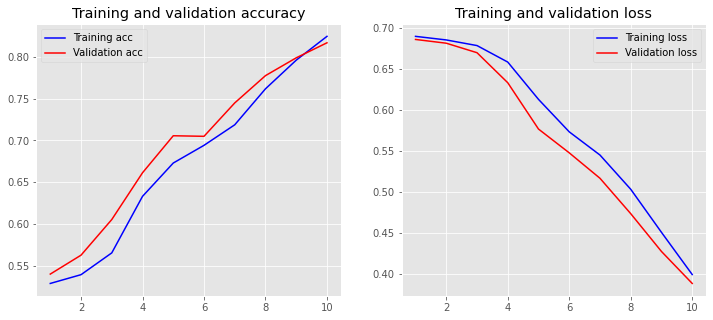

In [77]:
finalEvaluation(10,'CNN','SGD')

Building model
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 1400, 128)         640000    
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 1398, 250)         96250     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 250)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 125)               31375     
_________________________________________________________________
activation_14 (Activation)   (None, 125)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 126       
_________________________________________________________________
activation_15 (Activation)   (None, 1)

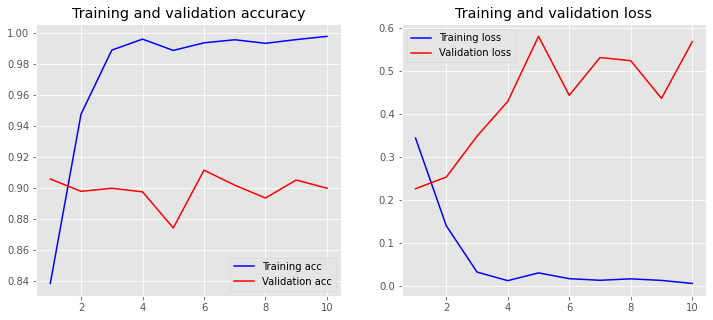

In [78]:
finalEvaluation(10,'CNN','adam')

Building model
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 1400, 128)         640000    
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1398, 250)         96250     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 250)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 125)               31375     
_________________________________________________________________
activation_16 (Activation)   (None, 125)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 126       
_________________________________________________________________
activation_17 (Activation)   (None, 1)

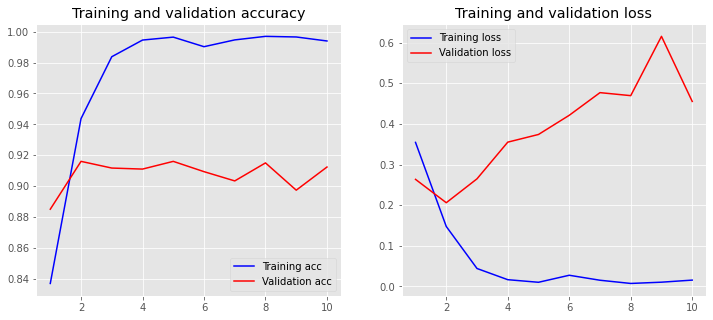

In [79]:
finalEvaluation(10,'CNN','Nadam')

Building model
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 1400, 128)         640000    
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1398, 250)         96250     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 250)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 125)               31375     
_________________________________________________________________
activation_18 (Activation)   (None, 125)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 126       
_________________________________________________________________
activation_19 (Activation)   (None, 1)

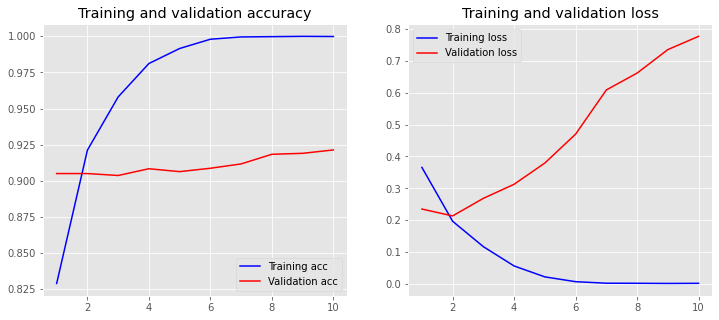

In [80]:
finalEvaluation(10,'CNN','rmsprop')